In [5]:
import numpy as np
import gymnasium as gym
import random
import time
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class Agent:
    def __init__(self, algorithm='SARSA'):
        self.algorithm = algorithm
        self.env = gym.make('FrozenLake-v1', render_mode='rgb_array', map_name='4x4', is_slippery=True)
        self.num_episodes = 10000
        self.max_steps_per_episode = 100
        self.learning_rate = 0.1
        self.discount_rate = 0.99
        self.exploration_rate = 1
        self.max_exploration_rate = 1
        self.min_exploration_rate = 0.01
        self.exploration_decay_rate = 0.001

    def eps_action_selection(self, state):
        exploration_rate_threshold = random.uniform(0,1)
        if exploration_rate_threshold > self.exploration_rate:
            # exploitation
            return np.argmax(self.q_table[state,:])
        else:
            # exploration
            return self.env.action_space.sample()

    def initialize_q_table(self):
        self.q_table = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    def decay_epsilon(self, episode):
        self.exploration_rate = self.min_exploration_rate + \
            (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate*episode)
                
    def train(self):
        # initialize q table 
        self.initialize_q_table()

        # initialize rewards array for visualizing results 
        self.rewards_all_episodes = []

        # iterate over episodes
        for episode in tqdm(range(self.num_episodes)):
            
            # initialize new episode params
            state, _ = self.env.reset()
            done = False
            rewards = 0

            # select new action
            if self.algorithm == 'SARSA':
                action = self.eps_action_selection(state)
            
            # iterate over steps in episode
            for step in range(self.max_steps_per_episode): 
                
                # select new action 
                if self.algorithm == 'Q-learning':
                    action = self.eps_action_selection(state)

                # Take action 
                new_state, reward, done, _, _ = self.env.step(action)

                # select next action 
                if self.algorithm == 'SARSA':
                    new_action = self.eps_action_selection(new_state)
                
                # Update Q-table
                if self.algorithm == 'Q-learning':
                    self.q_table[state, action] += self.learning_rate * (reward + self.discount_rate * np.max(self.q_table[new_state, :]) - self.q_table[state, action])
                    # self.q_table[state, action] = self.q_table[state, action] * (1 - self.learning_rate) + self.learning_rate * (reward + self.discount_rate * np.max(self.q_table[new_state, :]))
                elif self.algorithm == 'SARSA':
                    self.q_table[state, action] += self.learning_rate * (reward + self.discount_rate * self.q_table[new_state, new_action] - self.q_table[state, action])

                # Set new state
                state = new_state
                if self.algorithm == 'SARSA':
                    action = new_action

                # Add new reward        
                rewards += reward

                # check if done, and if so end the episode 
                if done == True: 
                    break

            # Exploration rate decay
            self.decay_epsilon(episode)   
            
            # Add current episode reward to total rewards list
            self.rewards_all_episodes.append(rewards)
    

# Q-Learning

100%|██████████| 10000/10000 [00:05<00:00, 1981.64it/s]

Average reward per thousand episodes



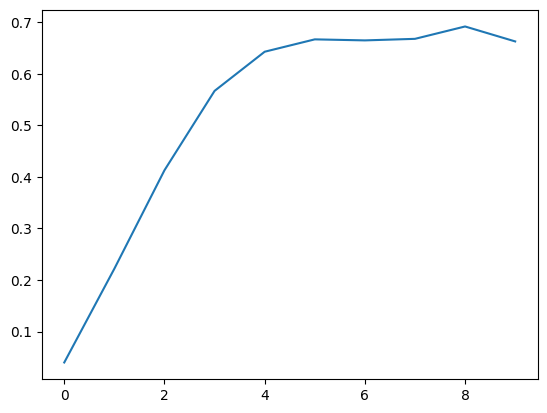

In [14]:
# create agent 
agent = Agent(algorithm='Q-learning')
agent.train()

# plot rewards
average_reward = []
rewards_per_thousand_episodes = np.split(np.array(agent.rewards_all_episodes),agent.num_episodes/1000)
count = 1000
print("Average reward per thousand episodes\n")
for r in rewards_per_thousand_episodes:
    average_reward.append(sum(r/1000))
    # print(count, ": ", str(sum(r/1000)))
    count += 1000

plt.plot(average_reward)

100%|██████████| 10000/10000 [00:03<00:00, 2912.55it/s]

Average reward per thousand episodes



Text(0.5, 1.0, 'SARSA')

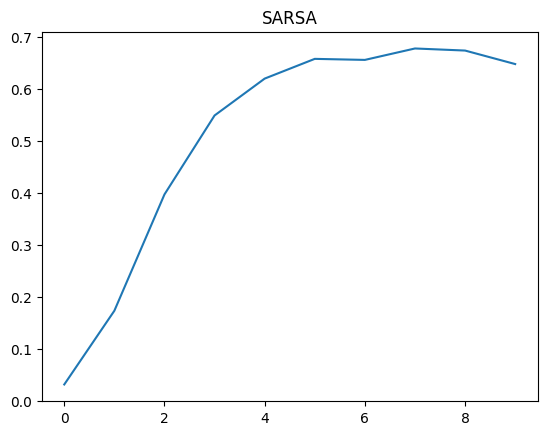

In [15]:
# create agent 
agent = Agent(algorithm='SARSA')
agent.train()

# plot rewards
average_reward = []
rewards_per_thousand_episodes = np.split(np.array(agent.rewards_all_episodes),agent.num_episodes/1000)
count = 1000
print("Average reward per thousand episodes\n")
for r in rewards_per_thousand_episodes:
    average_reward.append(sum(r/1000))
    # print(count, ": ", str(sum(r/1000)))
    count += 1000

plt.plot(average_reward)
plt.title(agent.algorithm)

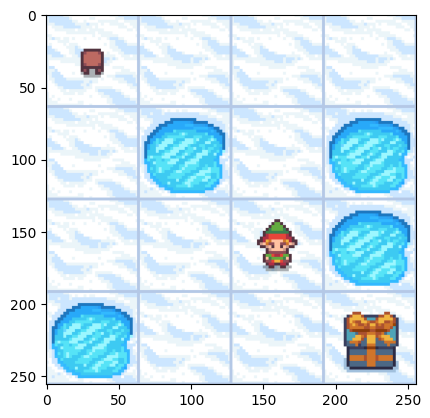

In [16]:
# Watch our agent play Frozen Lake by playing the best action 
# from each state according to the Q-table

for episode in range(3):
    # initialize new episode params
    state, _ = agent.env.reset()
    done = False
    print("*****EPISODE ", episode+1, "*****\n\n\n\n")
    time.sleep(1)

    for step in range(agent.max_steps_per_episode):        
        # Show current state of environment on screen
        clear_output(wait=True)
        # display gymnaisum environment
        plt.imshow(agent.env.render())
        plt.show()
        # print(env.render())
        time.sleep(0.3)

        # Choose action with highest Q-value for current state       
        action = np.argmax(agent.q_table[state,:]) 

        # Take new action
        new_state, reward, done, _, _ = agent.env.step(action)

        if done:
            if reward == 1:
                # Agent reached the goal and won episode
                time.sleep(3)
            else:
                # Agent stepped in a hole and lost episode            
                time.sleep(3)
                clear_output(wait=True)
            break

        # Set new state
        state = new_state

agent.env.close()